In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from collections import Counter
# optimizar el modelo con optimizacion de hiperparametros optuna
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv("./churn_prediction.csv")
df.shape

(28382, 21)

In [3]:
df.head()

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,current_balance,...,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn,last_transaction
0,1,2101,66,Male,0.0,self_employed,187.0,2,755,1458.71,...,1458.71,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0,2019-05-21
1,2,2348,35,Male,0.0,self_employed,NaN,2,3214,5390.37,...,7799.26,12419.41,0.56,0.56,5486.27,100.56,6496.78,8787.61,0,2019-11-01
2,4,2194,31,Male,0.0,salaried,146.0,2,41,3913.16,...,4910.17,2815.94,0.61,0.61,6046.73,259.23,5006.28,5070.14,0,NaT
3,5,2329,90,NaN,NaN,self_employed,1020.0,2,582,2291.91,...,2084.54,1006.54,0.47,0.47,0.47,2143.33,2291.91,1669.79,1,2019-08-06
4,6,1579,42,Male,2.0,self_employed,1494.0,3,388,927.72,...,1643.31,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1,2019-11-03


In [4]:
df['churn'].unique()

array([0, 1], dtype=int64)

In [5]:
df.describe()

,customer_id,vintage,age,dependents,city,customer_nw_category,branch_code,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
count,28382.000000,28382.000000,28382.000000,25919.000000,27579.000000,28382.000000,28382.000000,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,28382.000000
mean,15143.508667,2091.144105,48.208336,0.347236,796.109576,2.225530,925.975019,7.380552e+03,7.495771e+03,7.496780e+03,7.124209e+03,3.433252e+03,3.261694e+03,3.658745e+03,3.339761e+03,7.451133e+03,7.495177e+03,0.185329
std,8746.454456,272.676775,17.807163,0.997661,432.872102,0.660443,937.799129,4.259871e+04,4.252935e+04,4.172622e+04,4.457581e+04,7.707145e+04,2.968889e+04,5.198542e+04,2.430111e+04,4.203394e+04,4.243198e+04,0.388571
min,1.000000,73.000000,1.000000,0.000000,0.000000,1.000000,1.000000,-5.503960e+03,-3.149570e+03,1.428690e+03,-1.650610e+04,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,-3.374180e+03,-5.171920e+03,0.000000
25%,7557.250000,1958.000000,36.000000,0.000000,409.000000,2.000000,176.000000,1.784470e+03,1.906000e+03,2.180945e+03,1.832507e+03,3.100000e-01,3.300000e-01,4.100000e-01,4.100000e-01,1.996765e+03,2.074407e+03,0.000000
50%,15150.500000,2154.000000,46.000000,0.000000,834.000000,2.000000,572.000000,3.281255e+03,3.379915e+03,3.542865e+03,3.359600e+03,6.100000e-01,6.300000e-01,9.193000e+01,1.099600e+02,3.447995e+03,3.465235e+03,0.000000
75%,22706.750000,2292.000000,60.000000,0.000000,1096.000000,3.000000,1440.000000,6.635820e+03,6.656535e+03,6.666887e+03,6.517960e+03,7.072725e+02,7.492350e+02,1.360435e+03,1.357553e+03,6.667958e+03,6.654693e+03,0.000000
max,30301.000000,2476.000000,90.000000,52.000000,1649.000000,3.000000,4782.000000,5.905904e+06,5.740439e+06,5.700290e+06,5.010170e+06,1.226985e+07,2.361808e+06,7.637857e+06,1.414168e+06,5.778185e+06,5.720144e+06,1.000000


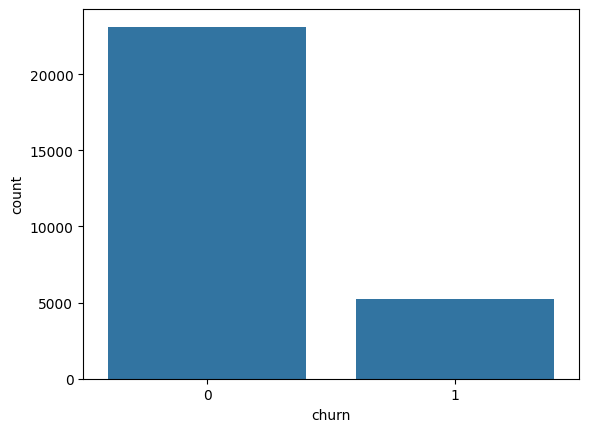

In [6]:
sns.countplot(x='churn',data=df)
plt.show()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28382 entries, 0 to 28381
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_id                     28382 non-null  int64  
 1   vintage                         28382 non-null  int64  
 2   age                             28382 non-null  int64  
 3   gender                          27857 non-null  object 
 4   dependents                      25919 non-null  float64
 5   occupation                      28302 non-null  object 
 6   city                            27579 non-null  float64
 7   customer_nw_category            28382 non-null  int64  
 8   branch_code                     28382 non-null  int64  
 9   current_balance                 28382 non-null  float64
 10  previous_month_end_balance      28382 non-null  float64
 11  average_monthly_balance_prevQ   28382 non-null  float64
 12  average_monthly_balance_prevQ2  

In [8]:
df.isnull().sum()

customer_id                          0
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
last_transaction                     0
dtype: int64

In [9]:
df['dependents'].unique()

array([ 0., nan,  2.,  3.,  1.,  7.,  4.,  6.,  5.,  9., 52., 36., 50.,
        8., 25., 32.])

In [10]:
df['occupation']=df['occupation'].fillna('self_employed')

In [11]:
df['dependents']=df['dependents'].fillna(0)

In [12]:
df['city']=df['city'].fillna(187)

In [13]:
import numpy as np
import random 

In [14]:
len(df['city'].unique())

1604

In [15]:
df

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,current_balance,...,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn,last_transaction
0,1,2101,66,Male,0.0,self_employed,187.0,2,755,1458.71,...,1458.71,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0,2019-05-21
1,2,2348,35,Male,0.0,self_employed,187.0,2,3214,5390.37,...,7799.26,12419.41,0.56,0.56,5486.27,100.56,6496.78,8787.61,0,2019-11-01
2,4,2194,31,Male,0.0,salaried,146.0,2,41,3913.16,...,4910.17,2815.94,0.61,0.61,6046.73,259.23,5006.28,5070.14,0,NaT
3,5,2329,90,NaN,0.0,self_employed,1020.0,2,582,2291.91,...,2084.54,1006.54,0.47,0.47,0.47,2143.33,2291.91,1669.79,1,2019-08-06
4,6,1579,42,Male,2.0,self_employed,1494.0,3,388,927.72,...,1643.31,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1,2019-11-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28377,30297,2325,10,Female,0.0,student,1020.0,2,1207,1076.43,...,2282.19,2787.70,0.30,0.30,0.30,0.30,1076.43,1076.43,0,2019-10-22
28378,30298,1537,34,Female,0.0,self_employed,1046.0,2,223,3844.10,...,3668.83,3865.55,1.71,2.29,901.00,1014.07,3738.54,3690.32,0,2019-12-17
28379,30299,2376,47,Male,0.0,salaried,1096.0,2,588,65511.97,...,53444.81,21925.81,4666.84,3883.06,168.23,71.80,61078.50,57564.24,1,2019-12-31
28380,30300,1745,50,Male,3.0,self_employed,1219.0,3,274,1625.55,...,1683.20,1857.42,0.20,0.20,0.20,0.20,1625.55,1625.55,0,NaT


In [16]:
df=df.drop(["last_transaction","customer_id"],axis=1)

In [17]:
df=pd.get_dummies(df)

In [18]:
df

,vintage,age,dependents,city,customer_nw_category,branch_code,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,...,current_month_balance,previous_month_balance,churn,gender_Female,gender_Male,occupation_company,occupation_retired,occupation_salaried,occupation_self_employed,occupation_student
0,2101,66,0.0,187.0,2,755,1458.71,1458.71,1458.71,1449.07,...,1458.71,1458.71,0,0,1,0,0,0,1,0
1,2348,35,0.0,187.0,2,3214,5390.37,8704.66,7799.26,12419.41,...,6496.78,8787.61,0,0,1,0,0,0,1,0
2,2194,31,0.0,146.0,2,41,3913.16,5815.29,4910.17,2815.94,...,5006.28,5070.14,0,0,1,0,0,1,0,0
3,2329,90,0.0,1020.0,2,582,2291.91,2291.91,2084.54,1006.54,...,2291.91,1669.79,1,0,0,0,0,0,1,0
4,1579,42,2.0,1494.0,3,388,927.72,1401.72,1643.31,1871.12,...,1157.15,1677.16,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28377,2325,10,0.0,1020.0,2,1207,1076.43,1076.43,2282.19,2787.70,...,1076.43,1076.43,0,1,0,0,0,0,0,1
28378,1537,34,0.0,1046.0,2,223,3844.10,4069.21,3668.83,3865.55,...,3738.54,3690.32,0,1,0,0,0,0,1,0
28379,2376,47,0.0,1096.0,2,588,65511.97,61017.55,53444.81,21925.81,...,61078.50,57564.24,1,0,1,0,0,1,0,0
28380,1745,50,3.0,1219.0,3,274,1625.55,1625.55,1683.20,1857.42,...,1625.55,1625.55,0,0,1,0,0,0,1,0


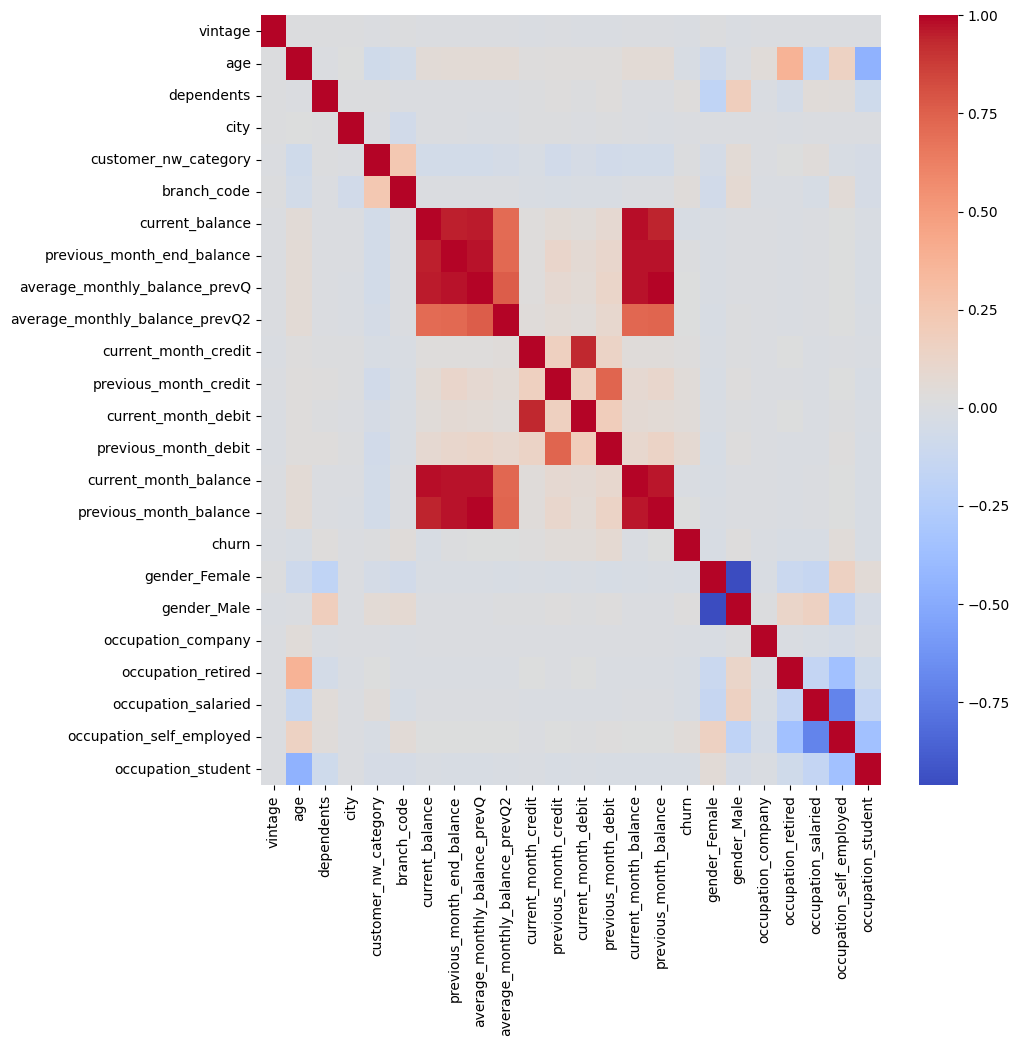

In [19]:
correlacion=df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlacion,cmap='coolwarm')
plt.show()

In [20]:
df.columns

Index(['vintage', 'age', 'dependents', 'city', 'customer_nw_category',
       'branch_code', 'current_balance', 'previous_month_end_balance',
       'average_monthly_balance_prevQ', 'average_monthly_balance_prevQ2',
       'current_month_credit', 'previous_month_credit', 'current_month_debit',
       'previous_month_debit', 'current_month_balance',
       'previous_month_balance', 'churn', 'gender_Female', 'gender_Male',
       'occupation_company', 'occupation_retired', 'occupation_salaried',
       'occupation_self_employed', 'occupation_student'],
      dtype='object')

In [21]:
x=df.drop('churn',axis=1)
y=df['churn']

In [22]:
x.shape,y.shape

((28382, 23), (28382,))

In [23]:
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=2024,stratify=y)

In [24]:
from sklearn.preprocessing import RobustScaler

In [25]:
Escalador=RobustScaler()
X_train=Escalador.fit_transform(X_train)
X_test=Escalador.transform(X_test)

In [26]:
logistica=LogisticRegression()
logistica.fit(X_train,y_train) #siempre igual

prediccion_logistica=logistica.predict(X_test)
print("classification_report",classification_report(y_test,prediccion_logistica))

probabilidad_logistica=logistica.predict_proba(X_test)[:,1]
Auc_logistica=roc_auc_score(y_test,probabilidad_logistica)

print("AUC",Auc_logistica)

classification_report               precision    recall  f1-score   support

           0       0.82      1.00      0.90      5781
           1       0.82      0.06      0.12      1315

    accuracy                           0.82      7096
   macro avg       0.82      0.53      0.51      7096
weighted avg       0.82      0.82      0.76      7096

AUC 0.7693793027243434


c:\Users\Mario_Suaza\anaconda3\envs\Data\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
rf=RandomForestClassifier()
rf.fit(X_train,y_train) #siempre igual

prediccion_rf=rf.predict(X_test)
print("classification_report",classification_report(y_test,prediccion_rf))

probabilidad_rf=rf.predict_proba(X_test)[:,1]
Auc_rf=roc_auc_score(y_test,probabilidad_rf)

print("AUC",Auc_rf)

classification_report               precision    recall  f1-score   support

           0       0.88      0.97      0.92      5781
           1       0.75      0.44      0.55      1315

    accuracy                           0.87      7096
   macro avg       0.82      0.70      0.74      7096
weighted avg       0.86      0.87      0.85      7096

AUC 0.8415915385591846


In [28]:
from sklearn.svm import SVC

svc=SVC(probability=True)
svc.fit(X_train,y_train) #siempre igual

prediccion_svc=svc.predict(X_test)
print("classification_report",classification_report(y_test,prediccion_svc))

probabilidad_svc=svc.predict_proba(X_test)[:,1]
Auc_svc=roc_auc_score(y_test,probabilidad_svc)

print("AUC",Auc_svc)

classification_report               precision    recall  f1-score   support

           0       0.82      1.00      0.90      5781
           1       0.77      0.03      0.05      1315

    accuracy                           0.82      7096
   macro avg       0.79      0.51      0.48      7096
weighted avg       0.81      0.82      0.74      7096

AUC 0.7941707560429702


In [29]:
xgboost=XGBClassifier()
xgboost.fit(X_train,y_train) #siempre igual

prediccion_xgboost=xgboost.predict(X_test)
print("classification_report",classification_report(y_test,prediccion_xgboost))

probabilidad_xgboost=xgboost.predict_proba(X_test)[:,1]
Auc_xgboost=roc_auc_score(y_test,probabilidad_xgboost)

print("AUC",Auc_xgboost)

classification_report               precision    recall  f1-score   support

           0       0.89      0.95      0.92      5781
           1       0.70      0.46      0.56      1315

    accuracy                           0.86      7096
   macro avg       0.79      0.71      0.74      7096
weighted avg       0.85      0.86      0.85      7096

AUC 0.8247547525228508


In [30]:
dt=DecisionTreeClassifier()
dt.fit(X_train,y_train) #siempre igual

prediccion_dt=dt.predict(X_test)
print("classification_report",classification_report(y_test,prediccion_dt))

probabilidad_dt=dt.predict_proba(X_test)[:,1]
Auc_dt=roc_auc_score(y_test,probabilidad_dt)

print("AUC",Auc_dt)

classification_report               precision    recall  f1-score   support

           0       0.88      0.87      0.87      5781
           1       0.45      0.48      0.46      1315

    accuracy                           0.80      7096
   macro avg       0.66      0.67      0.67      7096
weighted avg       0.80      0.80      0.80      7096

AUC 0.6718577903358518


In [31]:
from sklearn.naive_bayes import GaussianNB
nb=GaussianNB()
nb.fit(X_train,y_train) #siempre igual

prediccion_nb=nb.predict(X_test)
print("classification_report",classification_report(y_test,prediccion_nb))

probabilidad_nb=nb.predict_proba(X_test)[:,1]
Auc_nb=roc_auc_score(y_test,probabilidad_nb)

print("AUC",Auc_nb)

classification_report               precision    recall  f1-score   support

           0       0.85      0.34      0.49      5781
           1       0.20      0.73      0.32      1315

    accuracy                           0.41      7096
   macro avg       0.53      0.54      0.40      7096
weighted avg       0.73      0.41      0.46      7096

AUC 0.581545024575721


In [32]:
modelos=[("Logistic Regression",logistica),("Random Forest",rf),("XGBoost",xgboost),("Decision Tree",dt),("Naive Bayes",nb)]
resultados=[]
nombres=[]

for nombre,modelo in modelos:
    validacion_cruzada_estratificada= StratifiedKFold(n_splits=5,shuffle=True,random_state=2024)
    validacion_cruzada=cross_val_score(modelo,X_train,y_train,scoring='roc_auc',cv=validacion_cruzada_estratificada)
    nombres.append(nombre)
    resultados.append(validacion_cruzada)
    print("Modelo: ",nombre)
    print("fold",validacion_cruzada)
    print("Media AUC: ",np.mean(validacion_cruzada))


c:\Users\Mario_Suaza\anaconda3\envs\Data\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Mario_Suaza\anaconda3\envs\Data\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Modelo:  Logistic Regression
fold [0.75678004 0.7807987  0.75933759 0.77040602 0.76743955]
Media AUC:  0.7669523786952158
Modelo:  Random Forest
fold [0.82765147 0.84740751 0.82956778 0.83604288 0.82982196]
Media AUC:  0.834098320110298
Modelo:  XGBoost
fold [0.81412226 0.82839885 0.80670019 0.81926847 0.80923285]
Media AUC:  0.8155445227660462
Modelo:  Decision Tree
fold [0.66451434 0.67876204 0.65938883 0.66143743 0.66083058]
Media AUC:  0.6649866458340764
Modelo:  Naive Bayes
fold [0.5902513  0.59535434 0.59441784 0.58665795 0.5528599 ]
Media AUC:  0.5839082651544318


In [33]:
def objetive(trial):
    parametros={
        "n_estimators":trial.suggest_int("n_estimators",100,500),
        "max_depth":trial.suggest_int("max_depth",3,25),
        "learning_rate":trial.suggest_float("learning_rate",0.01,0.1)
    }
    modelo=XGBClassifier(**parametros)
    validacion_cruzada_estratificada= cross_val_score(modelo,X_train,y_train,scoring='roc_auc',cv=3)
    return validacion_cruzada_estratificada.mean()

study=optuna.create_study(direction="maximize",sampler=TPESampler())
study.optimize(objetive,n_trials=50)
print(study.best_trial)
print(study.best_params)
print(study.best_value)


[I 2024-10-03 19:10:03,328] A new study created in memory with name: no-name-3bb9e47d-5baf-44bf-a987-897579a2e711
[I 2024-10-03 19:10:05,358] Trial 0 finished with value: 0.8274887996614987 and parameters: {'n_estimators': 462, 'max_depth': 6, 'learning_rate': 0.037980712911811924}. Best is trial 0 with value: 0.8274887996614987.
[I 2024-10-03 19:10:09,383] Trial 1 finished with value: 0.8204549385274569 and parameters: {'n_estimators': 114, 'max_depth': 21, 'learning_rate': 0.08778848300162098}. Best is trial 0 with value: 0.8274887996614987.
[I 2024-10-03 19:10:10,539] Trial 2 finished with value: 0.835177695155053 and parameters: {'n_estimators': 478, 'max_depth': 4, 'learning_rate': 0.021536295567032918}. Best is trial 2 with value: 0.835177695155053.
[I 2024-10-03 19:10:18,248] Trial 3 finished with value: 0.8214139044158496 and parameters: {'n_estimators': 279, 'max_depth': 23, 'learning_rate': 0.06527675102616072}. Best is trial 2 with value: 0.835177695155053.
[I 2024-10-03 19:

FrozenTrial(number=21, state=TrialState.COMPLETE, values=[0.835536969345576], datetime_start=datetime.datetime(2024, 10, 3, 19, 11, 24, 488764), datetime_complete=datetime.datetime(2024, 10, 3, 19, 11, 25, 693395), params={'n_estimators': 465, 'max_depth': 4, 'learning_rate': 0.022870477775890942}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=25, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.1, log=False, low=0.01, step=None)}, trial_id=21, value=None)
{'n_estimators': 465, 'max_depth': 4, 'learning_rate': 0.022870477775890942}
0.835536969345576


In [34]:
xg_params=study.best_params
xg_params['random_state']=2024
xg=XGBClassifier(**xg_params)
xg.fit(X_train,y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.022870477775890942,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=465, n_jobs=None,
              num_parallel_tree=None, random_state=2024, ...)

In [35]:
y_predicho=xg.predict(X_test)
y_predicho_probabilidad=xg.predict_proba(X_test)[:,1]

In [36]:
roc_auc=roc_auc_score(y_test,y_predicho_probabilidad)

In [38]:
print(classification_report(y_test,y_predicho))
print("AUC",roc_auc)

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      5781
           1       0.72      0.46      0.56      1315

    accuracy                           0.87      7096
   macro avg       0.80      0.71      0.74      7096
weighted avg       0.86      0.87      0.86      7096

AUC 0.8446435583197349


In [39]:
import joblib

In [43]:
joblib.dump(xg,"modelo_churn.pkl")

['modelo_churn.pkl']

In [44]:
modeloCompartido=joblib.load("modelo_churn.pkl")

In [45]:
y_predicho_mario=modeloCompartido.predict(X_test)
y_predicho_mario_probabilidad=modeloCompartido.predict_proba(X_test)[:,1]
roc_auc=roc_auc_score(y_test,y_predicho_mario_probabilidad)
print(classification_report(y_test,y_predicho_mario))
print("AUC",roc_auc)

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      5781
           1       0.72      0.46      0.56      1315

    accuracy                           0.87      7096
   macro avg       0.80      0.71      0.74      7096
weighted avg       0.86      0.87      0.86      7096

AUC 0.8446435583197349


In [50]:
y_test

27322    0
25299    1
5609     1
11148    0
10901    0
        ..
23487    0
21917    0
11955    0
12392    0
25845    0
Name: churn, Length: 7096, dtype: int64

In [59]:
len(X_test[1])

23

In [65]:
predecir_valore_nuevo=modeloCompartido.predict([[66,  8956,  166,  21231,
        166,  1231,  45,  4521,
        665,  1235, 5623, 2133,
       23232, 96,  89,  232,
        166,  166,  166,  166,
        7878745, 89,  166]])

print(predecir_valore_nuevo)

[0]


In [66]:
from sklearn.pipeline import Pipeline

In [70]:
modelos2=XGBClassifier(max_depth=10,n_estimators=100,learning_rate=0.01,random_state=2024)

tuberia=Pipeline([('escalador',RobustScaler()),('modelo',modelos2)])
tuberia.fit(X_train,y_train)
y_predicho_tuberia=tuberia.predict(X_test)
y_predicho_probabilidad_tuberia=tuberia.predict_proba(X_test)[:,1]
roc_auc=roc_auc_score(y_test,y_predicho_probabilidad_tuberia)
print(classification_report(y_test,y_predicho_tuberia))
print("AUC",roc_auc)



              precision    recall  f1-score   support

           0       0.86      0.98      0.92      5781
           1       0.79      0.28      0.41      1315

    accuracy                           0.85      7096
   macro avg       0.82      0.63      0.66      7096
weighted avg       0.84      0.85      0.82      7096

AUC 0.8291774615019832


In [71]:
joblib.dump(tuberia,"modelo_churn_tuberia.pkl")

modeloCompartido2=joblib.load("modelo_churn_tuberia.pkl")
y_predicho_tuberia=modeloCompartido2.predict(X_test)
y_predicho_probabilidad_modeloCompartido2=modeloCompartido2.predict_proba(X_test)[:,1]
roc_auc=roc_auc_score(y_test,y_predicho_probabilidad_modeloCompartido2)
print(classification_report(y_test,y_predicho_tuberia))
print("AUC",roc_auc)

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      5781
           1       0.79      0.28      0.41      1315

    accuracy                           0.85      7096
   macro avg       0.82      0.63      0.66      7096
weighted avg       0.84      0.85      0.82      7096

AUC 0.8291774615019832
